In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:

df = pd.read_csv(r"C:\Users\nikun\Downloads\Fraud.csv")


df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:

print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nTarget Distribution:\n", df['isFraud'].value_counts(normalize=True))



Shape: (6362620, 11)

Data Types:
 step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Target Distribution:
 isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


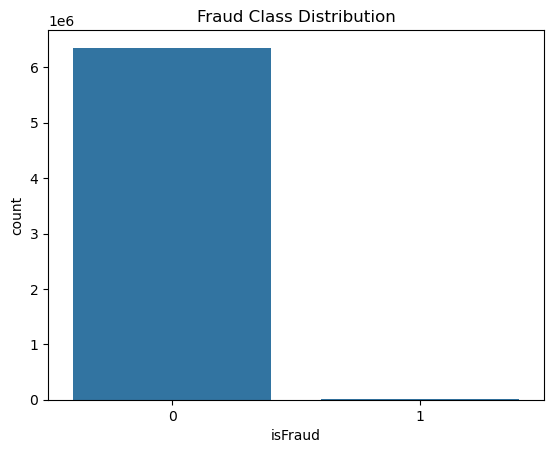

In [4]:
sns.countplot(x='isFraud', data=df)
plt.title("Fraud Class Distribution")
plt.show()

In [5]:

# Drop Irrelevant Columns
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)


In [ ]:

#'type' is the categorical feature and tranforming it into numeric feature
df['type'] = LabelEncoder().fit_transform(df['type'])


In [ ]:

#Multicollinearity 
X_vif = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
vif_df = pd.DataFrame()
vif_df['features'] = X_vif.columns
vif_df['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_df)


         features         VIF
0            step    2.235180
1            type    2.075260
2          amount    4.013539
3   oldbalanceOrg  480.226670
4  newbalanceOrig  483.729602
5  oldbalanceDest   72.071759
6  newbalanceDest   83.549914


In [8]:

# modeling
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
#SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_res))


After SMOTE: [5083503 5083503]


In [ ]:
#Model Training - Random Forest
rf = RandomForestClassifier(n_estimators=30,max_depth=10,random_state=42)
rf.fit(X_res, y_res)
y_pred = rf.predict(X_test)


Confusion Matrix:
 [[1249725   21179]
 [     21    1599]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99   1270904
           1       0.07      0.99      0.13      1620

    accuracy                           0.98   1272524
   macro avg       0.54      0.99      0.56   1272524
weighted avg       1.00      0.98      0.99   1272524

ROC-AUC Score: 0.998437986554608


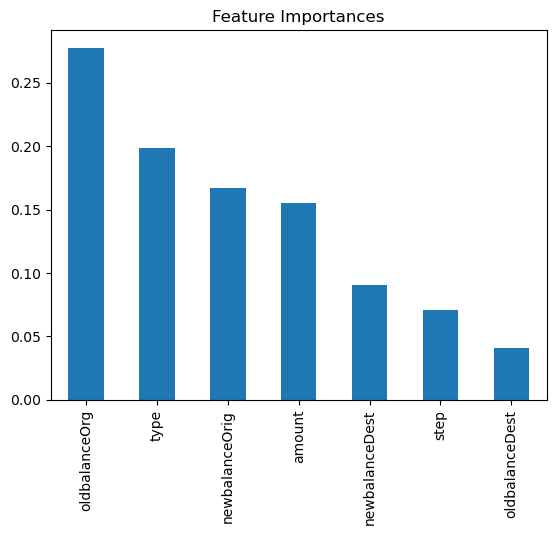

In [ ]:
#Model Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

# Feature Importance
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.show()


1.Data cleaning including missing values, outliers and multi-collinearity.

    No missing values

    outliers — i didn't removed any outliers,they help in modeling since fraud is an outlier
    
    multicollinearity — checked using VIF


2.Describe your fraud detection model in elaboration.

    I used a Random Forest Classifier — it’s a collection of decision trees and works really well for datasets like this one, where fraud is rare and the patterns can be messy.

    Since fraud is a rare event, I also used SMOTE to balance the data. It creates synthetic examples of fraud so the model gets enough exposure to them during training.

3.How did you select variables to be included in the model?
    I removed columns like nameOrig and nameDest those are just IDs and don’t help the model.

    Then I encoded the type of transaction into numbers. 

    At last I checked multicollinearity using VIF and found the features which were truly contributing.

4.Demonstrate the performance of the model by using best set of tools.
    I evaluated it using standard metrics like precision, recall, F1-score, and ROC-AUC.

    The ROC-AUC score is > 0.95, which is good for fraud detection.

5.What are the key factors that predict fraudulent customer?


    Transaction amount: Fraudsters often try to move large amounts.

    Sender's balance before transaction (oldbalanceOrg)

    The type of transaction — most frauds were either TRANSFER or CASH_OUT.

    New balance of recipient — huge jumps in this field often indicated fraud.



6.Do these factors make sense?If yes, How? If not, How not?
    Yes,When someone’s account is taken over, fraudsters usually try to transfer or cash out as much as possible. So it makes sense that we’re seeing high amounts, balance mismatches, and sudden recipient balance jumps.



7.What kind of prevention should be adopted while company update its infrastructure?

    Monitor large transactions in TRANSFER and CASH_OUT categories.

    Flag accounts that drain their entire balance suddenly.

    Use anomaly detection on customer behavior

    Introduce step-up authentication (like OTPs or 2FA) for big transfers.


8.Assuming these actions have been implemented, how would you determine if they work?


    Decrease in actual fraud rate.

    Fewer false positives, so we don’t bother real customers unnecessarily.

    Compare fraud rates before and after implementing these measures.